# Setup

In [1]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2 as cv

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
feature_data_folder = 'feature_data/'

In [3]:
#load all features & labels
#hog features
train_hog = np.load(feature_data_folder + 'hog/train_hog.npy')
test_hog = np.load(feature_data_folder + 'hog/test_hog.npy')
val_hog = np.load(feature_data_folder + 'hog/val_hog.npy')

#resnet feature maps
train_resnet = np.load(feature_data_folder + 'resnet18/train-fmaps.npy')
test_resnet = np.load(feature_data_folder + 'resnet18/test-fmaps.npy')
val_resnet = np.load(feature_data_folder + 'resnet18/val-fmaps.npy')

#sift features
train_sift = np.load(feature_data_folder + 'sift/train_sift.npy')
test_sift = np.load(feature_data_folder + 'sift/test_sift.npy')
val_sift = np.load(feature_data_folder + 'sift/val_sift.npy')

#load labels
train_labels = np.load(feature_data_folder + 'resnet18/train-labels.npy')
test_labels = np.load(feature_data_folder + 'resnet18/test-labels.npy')
val_labels = np.load(feature_data_folder + 'resnet18/val-labels.npy')

In [4]:
print(train_hog.shape)
print(train_resnet.shape)
print(train_sift.shape)
print(train_labels.shape)

(8960, 1000)
(8960, 512)
(8960, 1500)
(8960,)


In [5]:
#concat all features into 1d vector
train_features = np.concatenate((train_hog, train_resnet, train_sift), axis = 1)
test_features = np.concatenate((test_hog, test_resnet, test_sift), axis = 1)
val_features = np.concatenate((val_hog, val_resnet, val_sift), axis = 1)

In [6]:
#2 feature testing
train_features_2 = np.concatenate((train_resnet, train_sift), axis = 1)
test_features_2 = np.concatenate((test_resnet, test_sift), axis = 1)
val_features_2 = np.concatenate((val_resnet, val_sift), axis = 1)

# Baseline LR

In [17]:
base_clf = LogisticRegression(max_iter = 1000).fit(train_features, train_labels)
print(base_clf.score(train_features, train_labels))
print(base_clf.score(val_features, val_labels))

1.0
0.6238997968855788


In [8]:
#trying w l1 regularization and solver = saga
clf = LogisticRegression(max_iter = 1000, penalty = 'l1', solver = 'saga', C = 0.01).fit(train_features, train_labels)

In [9]:
clf.score(train_features, train_labels)

0.8116071428571429

In [ ]:
clf.score(val_features, val_labels)

In [7]:
clf = LogisticRegression(max_iter = 1000, penalty = 'l1', solver = 'saga')
param_grid={'C':[0.01,0.1]} 
clf_grid=GridSearchCV(clf,param_grid)
clf_grid.fit(train_features, train_labels)
print(clf_grid.best_params_)
print(clf_grid.score(train_features, train_labels))
print(clf_grid.score(val_features, val_labels))

C:\Users\linni\anaconda3\envs\comp_vision\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\linni\anaconda3\envs\comp_vision\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\linni\anaconda3\envs\comp_vision\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\linni\anaconda3\envs\comp_vision\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\linni\anaconda3\envs\comp_vision\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\linni\anaconda3\

{'C': 0.01}
0.8108258928571429
0.6672308733920108


C:\Users\linni\anaconda3\envs\comp_vision\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [11]:
preds = clf.predict(train_features)
corr = preds == train_labels

In [12]:
df = pd.DataFrame({'correct': corr, 'label': train_labels})

Text(0, 0.5, 'Count')

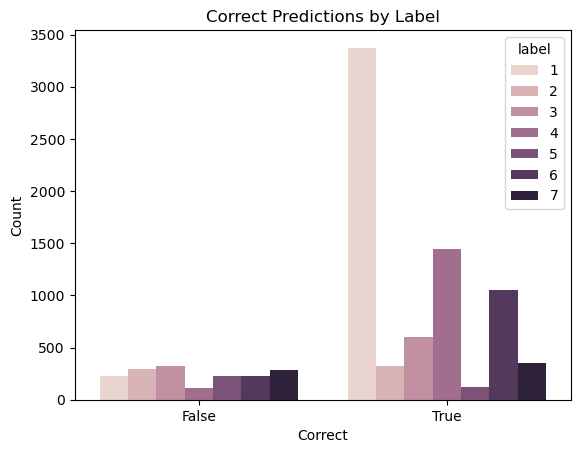

In [13]:
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

# SVM

In [90]:
svc_clf = svm.SVC(class_weight = 'balanced').fit(train_features, train_labels)

In [91]:
svc_clf.score(train_features, train_labels)

0.9762276785714286

In [92]:
svc_clf.score(val_features, val_labels)

0.6811103588354773

Text(0, 0.5, 'Count')

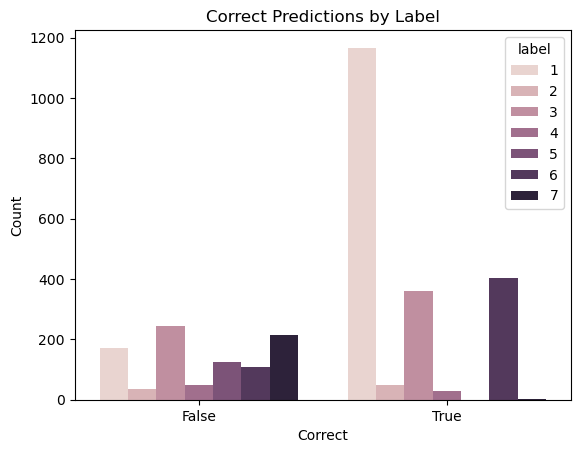

In [93]:
preds = svc_clf.predict(val_features)
corr = preds == val_labels
df = pd.DataFrame({'correct': corr, 'label': val_labels})
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

## Class Rebalancing

In [95]:
unique, counts = np.unique(train_labels, return_counts = True)
print(unique, counts) #min count is 343
min_label = min(counts)
print(min_label)

[1 2 3 4 5 6 7] [3598  616  924 1561  343 1281  637]
343


In [101]:
balanced_ids = []
for label in np.unique(train_labels):
    balanced_ids.append(np.where(train_labels == label)[0][:min_label])
balanced_ids = np.array(balanced_ids).flatten()
balanced_train_labels = train_labels[balanced_ids]
balanced_train_features = train_features[balanced_ids]

In [103]:
print(balanced_train_labels.shape)
print(balanced_train_features.shape)

(2401,)
(2401, 3012)


In [104]:
svc_clf = svm.SVC(class_weight = 'balanced').fit(balanced_train_features, balanced_train_labels)

In [105]:
svc_clf.score(balanced_train_features, balanced_train_labels)

0.9862557267805081

In [106]:
svc_clf.score(val_features, val_labels)

0.5457007447528774

Text(0, 0.5, 'Count')

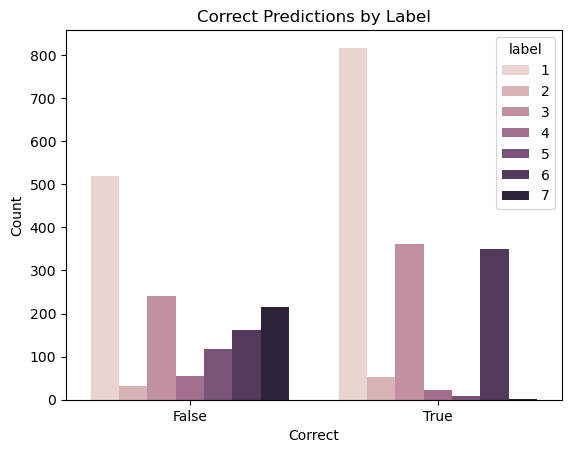

In [107]:
preds = svc_clf.predict(val_features)
corr = preds == val_labels
df = pd.DataFrame({'correct': corr, 'label': val_labels})
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

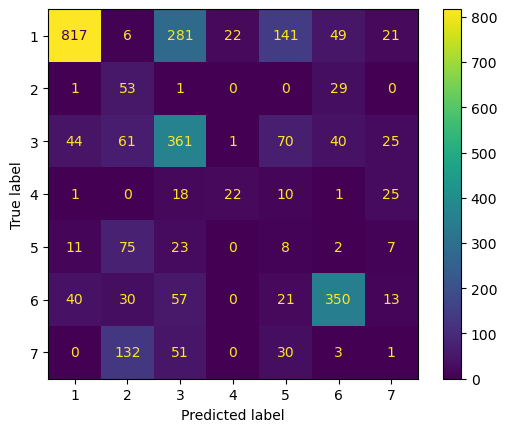

In [112]:
#confusion matrix
cm = confusion_matrix(val_labels, preds, labels = svc_clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels = svc_clf.classes_)
disp.plot()
plt.show()

# Linear SVM

In [85]:
linear_svc = svm.LinearSVC().fit(train_features, train_labels)

In [86]:
linear_svc.score(train_features, train_labels)

1.0

In [87]:
linear_svc.score(val_features, val_labels)

0.576506431956669

# PCA

In [127]:
pca = PCA()
pca.fit(train_features)

PCA()

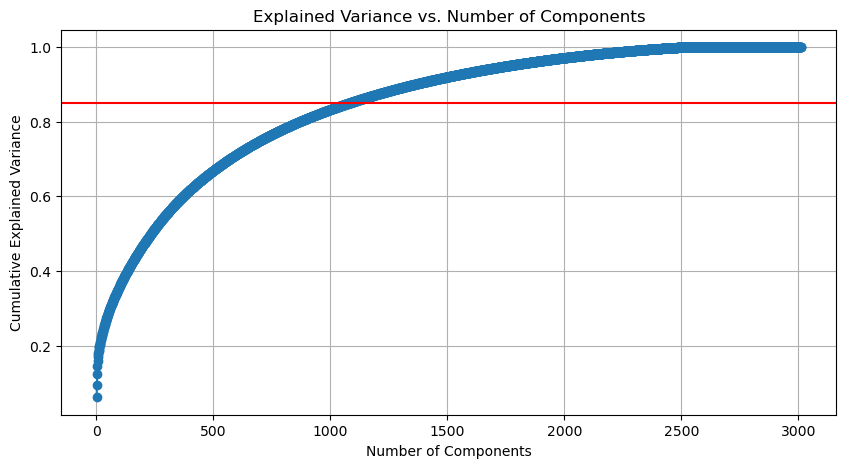

In [128]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
# draw a line at 90% of explained variance
plt.axhline(y=0.85, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [134]:
pca = PCA(n_components=1000)
pca.fit(train_features)

PCA(n_components=1000)

In [135]:
train_features_pca = pca.transform(train_features)
val_features_pca = pca.transform(val_features)
test_features_pca = pca.transform(test_features)

In [136]:
svc_clf = svm.SVC(class_weight = 'balanced').fit(train_features_pca, train_labels)

In [137]:
svc_clf.score(train_features_pca, train_labels)

0.9739955357142858

In [138]:
svc_clf.score(val_features_pca, val_labels)

0.6641841570751523